## CNN
This section covers :
- Convolutionnal layers
- MaxPooling
- Save/Load model

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

100.0%


Extracting ./data2/cifar-10-python.tar.gz to ./data2
Files already downloaded and verified


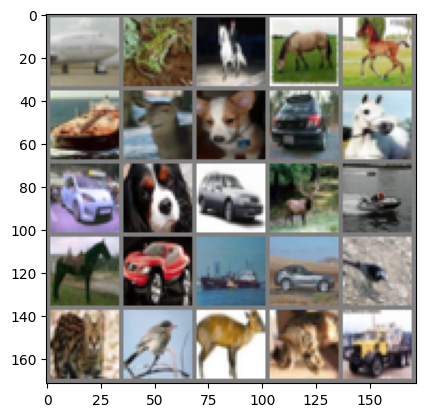

In [3]:
#device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Hyper-parameters
num_epochs = 10
batch_size = 32
lr = 0.001

#dataset hasPILIMAGE images of range [0,1]
#We transfor them to Tesnors of normalized range [-1,1]
transforms = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]
)

#CIFAR10 : 60000 32*32 color images in 10 classes , with 6000 images per class
train_dataset = torchvision.datasets.CIFAR10(root='./data2',train=True,
                                            download=True,transform=transforms)
test_dataset = torchvision.datasets.CIFAR10(root='./data2',train=False,
                                           download=True,transform=transforms)
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

classes = ('plane','car','bird','cat','deer','dog','frog','horse','ship','truck')

def imshow(imgs):
    imgs = imgs / 2 +0.5
    npimg = imgs.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()

#one batch of random taining images
dataiter = iter(train_loader)
images,labels = next(dataiter)
img_grid = torchvision.utils.make_grid(images[0:25],nrow=5)
imshow(img_grid)

In [4]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,32,3)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(32,64,3)
        self.conv3 = nn.Conv2d(64,64,3)
        self.fc1 = nn.Linear(64*4*4,64)
        self.fc2 = nn.Linear(64,10)

    def forward(self,x):
        #N, 3, 32, 32
        x = F.relu(self.conv1(x)) #N,32,30,30
        x = self.pool(x) #N 32 15 15
        x = F.relu(self.conv2(x)) #N 64 13 13
        x = self.pool(x) #N 64 6 6
        x = F.relu(self.conv3(x)) #N 64 4 4 
        x = torch.flatten(x,1) #N 1024
        x = F.relu(self.fc1(x)) #N 64
        x = self.fc2(x) #N 10
        return x

model = ConvNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = lr)

n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (images,labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        #Forwardpass
        outputs = model(images)
        loss = criterion(outputs,labels)

        #Backward and optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'[{epoch+1}] loss : {running_loss/n_total_steps:.3f}')

print('Finished training')
PATH = './cnn.pth'
torch.save(model.state_dict(),PATH)
        

[1] loss : 1.468
[2] loss : 1.109
[3] loss : 0.948
[4] loss : 0.850
[5] loss : 0.774
[6] loss : 0.718
[7] loss : 0.667
[8] loss : 0.630
[9] loss : 0.594
[10] loss : 0.558
Finished training


In [6]:
loaded_model = ConvNet()
loaded_model.load_state_dict(torch.load(PATH))
loaded_model.to(device)
loaded_model.eval()
with torch.no_grad():
    n_correct = 0
    n_correct2 = 0
    n_samples = len(test_loader.dataset)

    for images,labels in test_loader :
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)

        #max returns (value,index)
        _,predicted= torch.max(outputs,1)
        n_correct += (predicted == labels).sum().item()
    
        outputs2 = loaded_model(images)
        _,predicted2 = torch.max(outputs2,1)
        n_correct2 += (predicted2 == labels).sum().item()
    acc = 100.0 * n_correct /n_samples
    print(acc)
    acc = 100.0 * n_correct2/n_samples
    print(acc)

/tmp/ipykernel_39772/3309644943.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(PATH))


72.07
72.07
